In [24]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [21]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [8]:
# Downloading KITTI object detection dataset
!gdown https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip
!gdown https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip

Downloading...
From: https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip
To: /content/data_object_image_2.zip
100% 12.6G/12.6G [08:28<00:00, 24.7MB/s]


In [9]:
# making directory for dataset extraction
!mkdir /content/drive/MyDrive/vehicle_detection/kitti_dataset

In [10]:
# Extracting dataset
!unzip -qx data_object_image_2.zip -d /content/drive/MyDrive/vehicle_detection/kitti_dataset/
!unzip -qx data_object_label_2.zip -d /content/drive/MyDrive/vehicle_detection/kitti_dataset/

In [27]:
# %cd drive/MyDrive/vehicle_detection/
%cd /content/drive/MyDrive/vehicle_detection

/content/drive/MyDrive/vehicle_detection


In [28]:
!pwd

/content/drive/MyDrive/vehicle_detection


In [3]:
"""
Ingestor for KITTI formats.

http://www.cvlibs.net/datasets/kitti/eval_object.php

Per devkit docs:

All values (numerical or strings) are separated via spaces,
each row corresponds to one object. The 15 columns represent:

#Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.


"""

In [4]:
import cv2
import shutil
import matplotlib.pyplot as plt
import os
from glob import glob
import random


In [8]:
class_names =  ['Truck','Car', 'Van','Cyclist', 'Tram']

Truck 569.25 125.75 642.77 214.80
Car 31.61 193.32 129.71 230.77
Car 104.42 188.01 188.34 220.56
Car 183.23 187.33 245.86 217.54
Car 227.36 189.17 281.98 211.96
DontCare 493.86 154.57 525.19 183.59
DontCare 645.63 163.86 684.67 184.57


(-0.5, 1241.5, 374.5, -0.5)

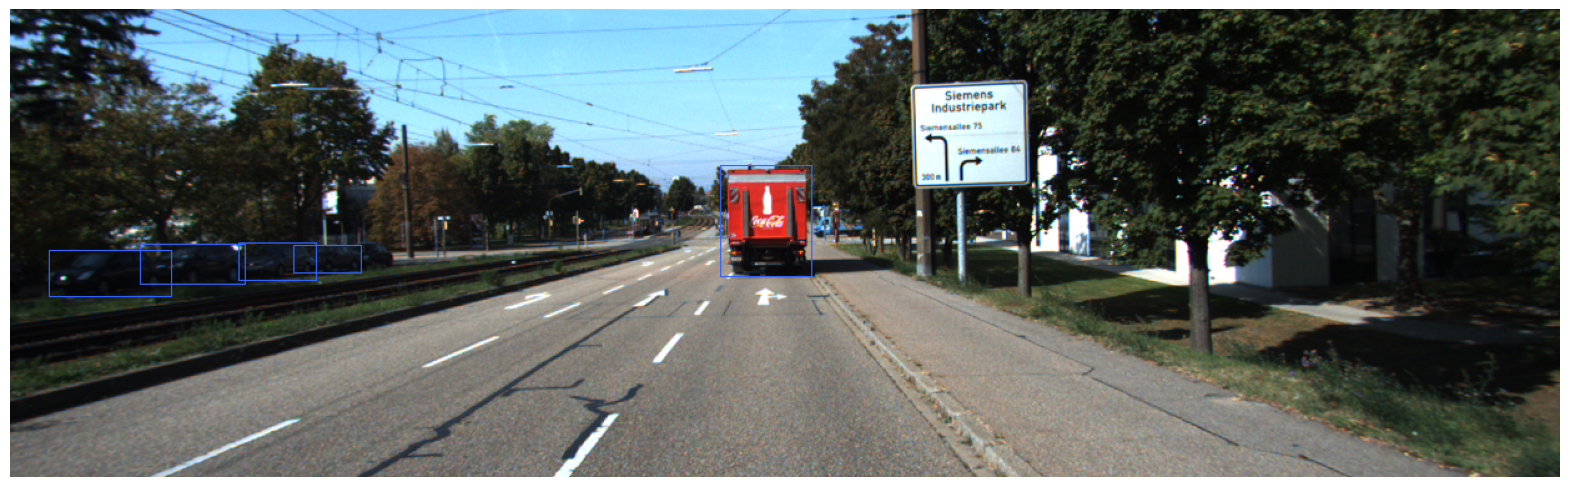

In [9]:
label_name = "./kitti_dataset/training/label_2/000055.txt"
img_name = "./kitti_dataset/training/image_2/000055.png"
img = cv2.imread(img_name)
color = (255,100,50)
with open(label_name) as fr:
  lines = fr.readlines()
  for line in lines:
    cls_name,_,_,_,left,top,right,bottom,*_= line.split(" ")
    print(cls_name,left,top,right,bottom)
    if(cls_name in class_names):
      cv2.rectangle(img , (int(float(left)), int(float(top))), (int(float(right)), int(float(bottom))), color , 1)
plt.figure(figsize = (20,10))
plt.imshow(img[:,:,::-1])
plt.axis('off')

# Preparing Dataset for Training


In [10]:
imges_dir = "./dataset/images"
label_dir = "./dataset/labels"

In [11]:
os.makedirs(imges_dir,exist_ok=True)
os.makedirs(label_dir,exist_ok=True)

In [12]:
train_imgs_dir = imges_dir+"/"+"train/"
train_lbl_dir = label_dir+"/"+"train/"

In [13]:
os.makedirs(train_imgs_dir,exist_ok=True)
os.makedirs(train_lbl_dir,exist_ok=True)

In [14]:
def resize_img(im , target_width = 640):
    h,w,_  = im.shape
    target_height = int(h / w * target_width)
    im = cv2.resize(im , (target_width , target_height), interpolation = cv2.INTER_AREA)
    return im

In [27]:
class_names =  ['Truck','Car', 'Van','Cyclist', 'Tram']
files = glob("./kitti_dataset/training/label_2/*.txt")
# splitting dataset for training and validation
random.shuffle(files)
tot_val_files = int(len(files)*0.20)
tot_train_files = len(files)-tot_val_files
print(tot_val_files,tot_train_files,len(files))

1496 5985 7481


In [29]:
for file in files[:tot_train_files]:
  label_str = ""
  file_name = file.split("/")[-1].split(".")[0]
  img = cv2.imread("./kitti_dataset/training/image_2/{}.png".format(file_name))
  img_h,img_w,_ = img.shape
  with open(file) as fr:
    lines = fr.readlines()
    for line in lines:
      cls_name,_,_,_,x1,y1,x2,y2,*_ = line.split(" ")
      x1,y1,x2,y2 = float(x1),float(y1),float(x2),float(y2)
      if cls_name in class_names:
        w = abs(x2-x1)
        h = abs(y1-y2)
        cx = (x1+w/2)/img_w
        cy = (y1+h/2)/img_h
        w = w/img_w
        h = h/img_h
        yolo_line = f'{0} {cx} {cy} {w} {h}\n'
        label_str +=yolo_line
  if(label_str):
    with open(train_lbl_dir+"kit_"+file_name+".txt",mode='w') as fw:
      fw.write(label_str)
    cv2.imwrite(train_imgs_dir+"kit_"+file_name+".png", resize_img(img))

# Validation Data Preparation

In [15]:
imgs_dir = imges_dir+"/"+"val/"
lbl_dir = label_dir+"/"+"val/"

In [16]:
os.makedirs(imgs_dir,exist_ok=True)
os.makedirs(lbl_dir,exist_ok=True)

In [32]:
for file in files[tot_train_files:]:
  label_str = ""
  file_name = file.split("/")[-1].split(".")[0]
  img = cv2.imread("./kitti_dataset/training/image_2/{}.png".format(file_name))
  img_h,img_w,_ = img.shape
  with open(file) as fr:
    lines = fr.readlines()
    for line in lines:
      cls_name,_,_,_,x1,y1,x2,y2,*_ = line.split(" ")
      x1,y1,x2,y2 = float(x1),float(y1),float(x2),float(y2)
      if cls_name in class_names:
        w = abs(x2-x1)
        h = abs(y1-y2)
        cx = (x1+w/2)/img_w
        cy = (y1+h/2)/img_h
        w = w/img_w
        h = h/img_h
        yolo_line = f'{0} {cx} {cy} {w} {h}\n'
        label_str +=yolo_line
  if(label_str):
    with open(lbl_dir+"kit_"+file_name+".txt",mode='w') as fw:
      fw.write(label_str)
    cv2.imwrite(imgs_dir+"kit_"+file_name+".png", resize_img(img))

# Merging The Urban Traffic Surveillance (UTS) dataset into KITTI Dataset

In [104]:
"""
%******************************************************************************************************************%
% The Urban Traffic Surveillance (UTS) dataset is collected with six videos which were captured from different     %
% viewpoints and illumination conditions.                                                                          %
% All the vehicles are annotated with bounding box, viewpoint, type and color.                                     %
% This dataset should be used for research only. Please DO NOT distribute or use it for commercial purpose.        %
%******************************************************************************************************************%
"""

In [18]:
# Extracting dataset
!unzip -qx UTS_Release.zip -d /content/drive/MyDrive/vehicle_detection/

0001.jpg


(-0.5, 1919.5, 1079.5, -0.5)

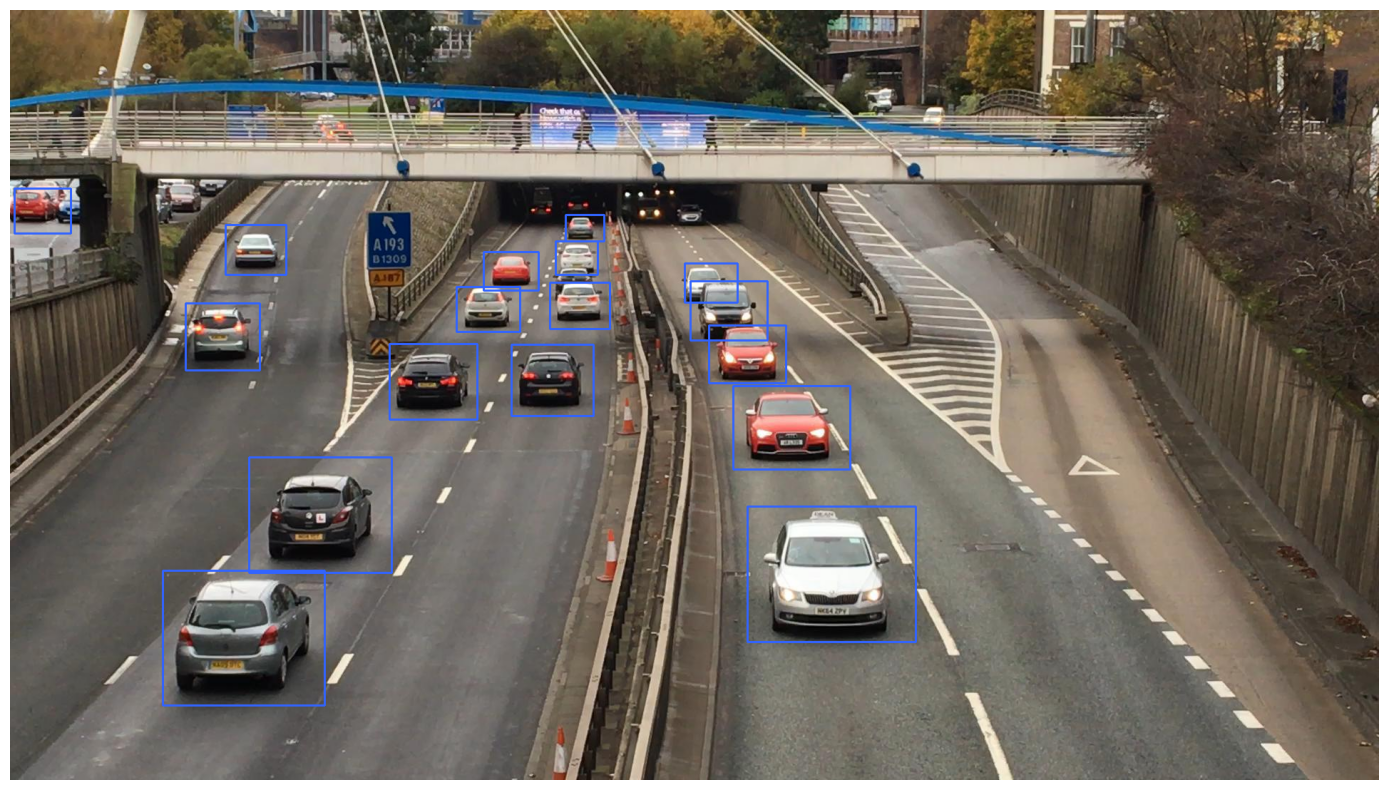

In [19]:
# BBOX visualization
txt_bboxes = "./UTS_Release/UTS_01_bbox.txt"
color = (255,100,50)
with open(txt_bboxes) as fr:
    lines = fr.readlines()
    for line in lines:
        splits = line.replace('\'',"").split()
        img_name = splits[0]
        splits = splits[1:]
        print(img_name)
        img = cv2.imread("./UTS_Release/UTS_01/{}".format(img_name))
        img_h,img_w,_ = img.shape
        slic = 4
        for i in range(len(splits)//4):
            x1,y1,w,h = splits[slic*i:slic*(i+1)]
            cv2.rectangle(img , (int(x1), int(y1)), (int(x1)+int(w), int(y1)+int(h)), color , 2)
            cx = (int(x1)+int(w)/2)/img_w
            cy = (int(y1)+int(h)/2)/img_h
            w = int(w)/img_w
            h = int(h)/img_h

#             print(x,y,w,h)
        break
plt.figure(figsize = (20,10))
plt.imshow(img[:,:,::-1])
plt.axis('off')

In [20]:
imges_dir = "./dataset/images"
label_dir = "./dataset/labels"
train_imgs_dir = imges_dir+"/"+"train/"
train_lbl_dir = label_dir+"/"+"train/"
imgs_dir = imges_dir+"/"+"val/"
lbl_dir = label_dir+"/"+"val/"

os.makedirs(imges_dir,exist_ok=True)
os.makedirs(label_dir,exist_ok=True)
os.makedirs(train_imgs_dir,exist_ok=True)
os.makedirs(train_lbl_dir,exist_ok=True)
os.makedirs(imgs_dir,exist_ok=True)
os.makedirs(lbl_dir,exist_ok=True)

In [21]:
# total 6 videos 15% images will transfer to validation dataset from each video
bbox_files = {"UTS_01_bbox.txt":"UTS_01","UTS_02_bbox.txt":"UTS_02",
              "UTS_03_bbox.txt":"UTS_03","UTS_04_bbox.txt":"UTS_04",
              "UTS_05_bbox.txt":"UTS_05","UTS_06_bbox.txt":"UTS_06"}

for bbox_file,img_folder in bbox_files.items():
    print(bbox_file,img_folder)
    img_counter = 0
    with open("./UTS_Release/{}".format(bbox_file)) as fr:
        for line in fr.readlines():
            splits = line.replace('\'',"").split()
            img_name = splits[0]
            splits = splits[1:]
            img = cv2.imread("./UTS_Release/{}/{}".format(img_folder,img_name))
            img_h,img_w,_ = img.shape
            slic = 4
            label_str = ""
            for i in range(len(splits)//4):
                x1,y1,w,h = splits[slic*i:slic*(i+1)]
                cx = (int(x1)+int(w)/2)/img_w
                cy = (int(y1)+int(h)/2)/img_h

                w = int(w)/img_w
                h = int(h)/img_h
                yolo_line = f'{0} {cx} {cy} {w} {h}\n'
                label_str +=yolo_line
                if img_counter < 470:
                    with open(train_lbl_dir+img_folder+"_"+img_name.split('.')[0]+".txt",mode='w') as fw:
                            fw.write(label_str)
                    cv2.imwrite(train_imgs_dir+img_folder+"_"+img_name, resize_img(img))
                else:
                    with open(lbl_dir+img_folder+"_"+img_name.split('.')[0]+".txt",mode='w') as fw:
                            fw.write(label_str)
                    cv2.imwrite(imgs_dir+img_folder+"_"+img_name, resize_img(img))
            img_counter+=1

UTS_01_bbox.txt UTS_01
UTS_02_bbox.txt UTS_02
UTS_03_bbox.txt UTS_03
UTS_04_bbox.txt UTS_04
UTS_05_bbox.txt UTS_05
UTS_06_bbox.txt UTS_06


#Training Yolov8

In [9]:
import torch
from IPython.display import clear_output
torch.cuda.get_device_name()


'Tesla V100-SXM2-16GB'

In [10]:
!pip install ultralytics

In [8]:
clear_output()
f = open('./dataset.yaml', 'w')
f.write('train: /content/drive/MyDrive/vehicle_detection/dataset/images/train')
f.write('\nval: /content/drive/MyDrive/vehicle_detection/dataset/images/val')
f.write('\nnc: {}'.format(1))
f.write("\nnames: ['vehicle']")

f.close()

In [ ]:
# !git clone https://github.com/ultralytics/ultralytics
# !cd ultralytics
# !pip install -e ultralytics

In [29]:
from ultralytics import YOLO

In [30]:
# Load the model
model = YOLO("yolov8m.pt")

In [34]:
# for resuming training we need to load last checkpoint model
# model = YOLO(model="./runs/detect/train/weights/last.pt")

In [35]:
# Training the model
model.train(data='./dataset.yaml', epochs=100, batch=32,plots=True,
            imgsz=640,resume=True)

Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=detect, mode=train, model=runs/detect/train/weights/last.pt, data=./dataset.yaml, epochs=100, time=None, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

train: Scanning /content/drive/MyDrive/vehicle_detection/dataset/labels/train.cache... 7723 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7723/7723 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/vehicle_detection/dataset/labels/val.cache... 1729 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1729/1729 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.5G     0.8652     0.4595     0.9277         92        640: 100%|██████████| 242/242 [03:25<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.77it/s]

                   all       1729       9450       0.94      0.888      0.957      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      13.7G     0.8572     0.4533     0.9272         83        640: 100%|██████████| 242/242 [03:12<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]

                   all       1729       9450      0.943      0.903      0.961      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      13.8G     0.8411     0.4429     0.9202        109        640: 100%|██████████| 242/242 [03:17<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.75it/s]

                   all       1729       9450      0.944      0.905      0.964       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      13.8G     0.8362     0.4366     0.9175        104        640: 100%|██████████| 242/242 [03:09<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.81it/s]

                   all       1729       9450      0.951      0.903      0.966       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      13.8G     0.8256     0.4302     0.9144        157        640: 100%|██████████| 242/242 [03:09<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.72it/s]

                   all       1729       9450      0.946      0.905      0.964      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      13.7G     0.8161     0.4262     0.9152         94        640: 100%|██████████| 242/242 [03:10<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:18<00:00,  1.48it/s]

                   all       1729       9450      0.946      0.916      0.968      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      13.8G     0.8089     0.4205     0.9101        135        640: 100%|██████████| 242/242 [03:21<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]

                   all       1729       9450      0.937      0.911      0.963      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      13.7G     0.8037     0.4163     0.9095        120        640: 100%|██████████| 242/242 [03:15<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.76it/s]

                   all       1729       9450      0.948      0.919      0.969      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      13.7G     0.7923     0.4119     0.9046        128        640: 100%|██████████| 242/242 [03:22<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.58it/s]

                   all       1729       9450      0.947      0.912      0.967      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      13.7G     0.7921     0.4081     0.9036        126        640: 100%|██████████| 242/242 [03:26<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:19<00:00,  1.47it/s]

                   all       1729       9450      0.948      0.922      0.971      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      13.7G     0.7776     0.4023     0.8982        147        640: 100%|██████████| 242/242 [03:31<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:20<00:00,  1.35it/s]

                   all       1729       9450      0.947      0.918       0.97      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      13.8G     0.7717     0.3967     0.8957        148        640: 100%|██████████| 242/242 [03:33<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:18<00:00,  1.55it/s]

                   all       1729       9450      0.949       0.92       0.97      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      13.8G      0.765     0.3926     0.8931        119        640: 100%|██████████| 242/242 [03:40<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:19<00:00,  1.46it/s]

                   all       1729       9450      0.948      0.928      0.972      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      13.6G     0.7767        0.4     0.8992        111        640: 100%|██████████| 242/242 [03:38<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:18<00:00,  1.50it/s]

                   all       1729       9450       0.95      0.929      0.973      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      13.7G     0.7631     0.3928     0.8965         98        640: 100%|██████████| 242/242 [03:38<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]

                   all       1729       9450      0.953      0.929      0.972      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      13.6G     0.7621     0.3904     0.8961         97        640: 100%|██████████| 242/242 [03:32<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:22<00:00,  1.23it/s]

                   all       1729       9450      0.952      0.933      0.974      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      13.6G     0.7543     0.3858     0.8906        140        640: 100%|██████████| 242/242 [03:31<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:18<00:00,  1.55it/s]

                   all       1729       9450       0.95      0.936      0.975      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      13.5G     0.7527     0.3829     0.8904        131        640: 100%|██████████| 242/242 [03:31<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.63it/s]


                   all       1729       9450       0.96      0.929      0.975      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      13.8G     0.7465     0.3807     0.8904         95        640: 100%|██████████| 242/242 [03:23<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.58it/s]

                   all       1729       9450       0.96      0.933      0.976      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      13.8G       0.74      0.376     0.8861        140        640: 100%|██████████| 242/242 [03:32<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.58it/s]

                   all       1729       9450      0.956      0.938      0.977       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      13.8G     0.7304     0.3726     0.8863        112        640: 100%|██████████| 242/242 [03:30<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.60it/s]

                   all       1729       9450      0.953      0.938      0.977      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      13.8G     0.7289     0.3716     0.8849        117        640: 100%|██████████| 242/242 [03:26<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.72it/s]

                   all       1729       9450      0.955      0.948      0.978      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      13.8G     0.7326     0.3721     0.8845        129        640: 100%|██████████| 242/242 [03:16<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.70it/s]

                   all       1729       9450      0.959       0.94      0.979      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      13.7G      0.727     0.3669     0.8824        124        640: 100%|██████████| 242/242 [03:21<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.56it/s]

                   all       1729       9450      0.957      0.941      0.979       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      13.8G     0.7206     0.3649     0.8813        132        640: 100%|██████████| 242/242 [03:21<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.63it/s]

                   all       1729       9450      0.961      0.943       0.98       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      13.7G     0.7189     0.3635     0.8778        140        640: 100%|██████████| 242/242 [03:16<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.73it/s]


                   all       1729       9450      0.959      0.946       0.98      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      13.7G     0.7071     0.3583     0.8764        132        640: 100%|██████████| 242/242 [03:16<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.74it/s]

                   all       1729       9450      0.959      0.946       0.98       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      13.7G     0.7041     0.3564     0.8771        173        640: 100%|██████████| 242/242 [03:13<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.75it/s]

                   all       1729       9450      0.961      0.941       0.98      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      13.7G     0.7014     0.3544     0.8725        135        640: 100%|██████████| 242/242 [03:12<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.85it/s]

                   all       1729       9450       0.96      0.946       0.98      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      13.6G     0.7032     0.3545     0.8734        103        640: 100%|██████████| 242/242 [03:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.76it/s]

                   all       1729       9450      0.963      0.945      0.981      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      13.6G     0.7012     0.3516     0.8746         92        640: 100%|██████████| 242/242 [03:11<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.80it/s]

                   all       1729       9450      0.963      0.947      0.982      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      13.8G     0.6976     0.3487     0.8745        152        640: 100%|██████████| 242/242 [03:07<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.73it/s]

                   all       1729       9450       0.96      0.947       0.98       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      13.6G     0.6919     0.3483     0.8711        149        640: 100%|██████████| 242/242 [03:13<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]

                   all       1729       9450      0.965      0.949      0.982      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      13.8G      0.686     0.3456     0.8695        168        640: 100%|██████████| 242/242 [03:09<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.74it/s]

                   all       1729       9450      0.965       0.95      0.982      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      13.5G     0.6846     0.3435     0.8706        111        640: 100%|██████████| 242/242 [03:12<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.78it/s]

                   all       1729       9450      0.964      0.945      0.982      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      13.8G     0.6813     0.3422     0.8691        180        640: 100%|██████████| 242/242 [03:06<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.83it/s]

                   all       1729       9450      0.964      0.947      0.983      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      13.8G     0.6808     0.3419     0.8644         84        640: 100%|██████████| 242/242 [03:09<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.77it/s]

                   all       1729       9450      0.965      0.948      0.983      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      13.6G     0.6667     0.3357     0.8629         85        640: 100%|██████████| 242/242 [03:07<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.72it/s]

                   all       1729       9450      0.965       0.95      0.982        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      13.8G     0.6699     0.3344     0.8639        141        640: 100%|██████████| 242/242 [03:09<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.74it/s]

                   all       1729       9450      0.963      0.954      0.983        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      13.5G     0.6665     0.3325     0.8648        121        640: 100%|██████████| 242/242 [03:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.76it/s]

                   all       1729       9450      0.964      0.951      0.983      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      13.7G     0.6682     0.3334     0.8676        132        640: 100%|██████████| 242/242 [03:11<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.82it/s]

                   all       1729       9450      0.968      0.948      0.984      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      13.8G     0.6688     0.3325     0.8645        126        640: 100%|██████████| 242/242 [03:11<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.76it/s]

                   all       1729       9450      0.965      0.952      0.984        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      13.8G     0.6535      0.325     0.8641        120        640: 100%|██████████| 242/242 [03:07<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.78it/s]

                   all       1729       9450      0.966      0.953      0.984      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      13.8G     0.6611     0.3271     0.8624        106        640: 100%|██████████| 242/242 [03:06<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.78it/s]

                   all       1729       9450      0.968      0.954      0.984      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      13.6G     0.6534     0.3245     0.8635        113        640: 100%|██████████| 242/242 [03:12<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.86it/s]

                   all       1729       9450      0.962      0.958      0.984      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      13.7G     0.6561     0.3225     0.8595        152        640: 100%|██████████| 242/242 [03:06<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.78it/s]

                   all       1729       9450      0.966      0.953      0.984      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      13.8G     0.6465     0.3195     0.8581        137        640: 100%|██████████| 242/242 [03:12<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.72it/s]

                   all       1729       9450      0.966      0.953      0.984      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      13.7G     0.6431     0.3178     0.8573        122        640: 100%|██████████| 242/242 [03:09<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.82it/s]

                   all       1729       9450      0.966      0.956      0.985      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      13.8G     0.6415     0.3166     0.8587        106        640: 100%|██████████| 242/242 [03:11<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.79it/s]

                   all       1729       9450      0.969      0.956      0.985       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      13.8G     0.6361     0.3168     0.8584        108        640: 100%|██████████| 242/242 [03:06<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.77it/s]

                   all       1729       9450      0.967      0.957      0.985      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      13.8G     0.6367     0.3138     0.8564        152        640: 100%|██████████| 242/242 [03:08<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.64it/s]

                   all       1729       9450      0.969      0.957      0.985      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      13.7G     0.6334     0.3123     0.8563        120        640: 100%|██████████| 242/242 [03:15<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:18<00:00,  1.55it/s]

                   all       1729       9450      0.968      0.957      0.985       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      13.7G     0.6271     0.3085     0.8556        114        640: 100%|██████████| 242/242 [03:28<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.60it/s]

                   all       1729       9450      0.969      0.955      0.985      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      13.7G     0.6214     0.3077     0.8512        117        640: 100%|██████████| 242/242 [03:26<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.57it/s]

                   all       1729       9450      0.968      0.959      0.986      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      13.7G     0.6231     0.3062     0.8526        122        640: 100%|██████████| 242/242 [03:25<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]

                   all       1729       9450      0.966      0.962      0.985      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      13.6G     0.6179     0.3037     0.8517        139        640: 100%|██████████| 242/242 [03:22<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.70it/s]

                   all       1729       9450      0.967      0.961      0.985      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      13.6G     0.6207     0.3037     0.8516        101        640: 100%|██████████| 242/242 [03:20<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:18<00:00,  1.49it/s]

                   all       1729       9450      0.967       0.96      0.986      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      13.7G     0.6131     0.2999     0.8493        118        640: 100%|██████████| 242/242 [03:15<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.77it/s]

                   all       1729       9450      0.968      0.959      0.986      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      13.5G     0.6111     0.2991     0.8501        143        640: 100%|██████████| 242/242 [03:26<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:19<00:00,  1.41it/s]


                   all       1729       9450      0.967      0.961      0.986      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      13.6G     0.6079     0.2978     0.8507        142        640: 100%|██████████| 242/242 [03:25<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.62it/s]

                   all       1729       9450      0.966      0.961      0.986      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      13.6G      0.606     0.2944     0.8474        172        640: 100%|██████████| 242/242 [03:22<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]

                   all       1729       9450      0.967      0.958      0.986      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      13.8G     0.6053     0.2944     0.8487        112        640: 100%|██████████| 242/242 [03:24<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.63it/s]


                   all       1729       9450      0.971      0.955      0.986      0.817

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      13.8G     0.6042     0.2935     0.8475        189        640: 100%|██████████| 242/242 [03:19<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.61it/s]

                   all       1729       9450      0.972      0.954      0.986      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      13.8G     0.6001     0.2927     0.8449        129        640: 100%|██████████| 242/242 [03:25<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]

                   all       1729       9450      0.968       0.96      0.986       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      13.5G      0.594     0.2894     0.8454        115        640: 100%|██████████| 242/242 [03:22<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.63it/s]

                   all       1729       9450      0.971      0.959      0.986      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      13.6G     0.5937     0.2892     0.8443        113        640: 100%|██████████| 242/242 [03:25<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]

                   all       1729       9450       0.97       0.96      0.986      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      13.8G      0.593     0.2873     0.8448        129        640: 100%|██████████| 242/242 [03:21<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]

                   all       1729       9450      0.969       0.96      0.986       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      13.8G     0.5956     0.2879     0.8455         99        640: 100%|██████████| 242/242 [03:26<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.61it/s]

                   all       1729       9450      0.971      0.959      0.986       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      13.8G     0.5916      0.284     0.8457        156        640: 100%|██████████| 242/242 [03:24<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.63it/s]

                   all       1729       9450      0.969       0.96      0.986      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      13.8G     0.5828     0.2823     0.8429        110        640: 100%|██████████| 242/242 [03:30<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]


                   all       1729       9450      0.968      0.962      0.986      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      13.8G     0.5805     0.2806     0.8452        153        640: 100%|██████████| 242/242 [03:21<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]

                   all       1729       9450       0.97      0.961      0.986      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      13.6G     0.5805     0.2781     0.8434         95        640: 100%|██████████| 242/242 [03:30<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.59it/s]

                   all       1729       9450       0.97       0.96      0.986      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      13.8G     0.5716     0.2759     0.8407        131        640: 100%|██████████| 242/242 [03:25<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.63it/s]

                   all       1729       9450       0.97      0.959      0.987      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      13.6G     0.5742     0.2762     0.8414        124        640: 100%|██████████| 242/242 [03:22<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]

                   all       1729       9450       0.97       0.96      0.986      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      13.8G     0.5648     0.2718     0.8396        148        640: 100%|██████████| 242/242 [03:19<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.72it/s]

                   all       1729       9450      0.971       0.96      0.986      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      13.7G     0.5665     0.2718     0.8394        140        640: 100%|██████████| 242/242 [03:15<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]

                   all       1729       9450       0.97       0.96      0.987      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      13.6G     0.5691     0.2724     0.8399        109        640: 100%|██████████| 242/242 [03:21<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]

                   all       1729       9450      0.968      0.963      0.986      0.827


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      13.7G     0.5795     0.2633     0.8376         50        640: 100%|██████████| 242/242 [03:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.76it/s]

                   all       1729       9450      0.971       0.96      0.987      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      13.7G     0.5676     0.2576     0.8352         66        640: 100%|██████████| 242/242 [02:56<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]

                   all       1729       9450      0.973      0.959      0.987      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      13.6G     0.5651     0.2559     0.8336         60        640: 100%|██████████| 242/242 [02:55<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.73it/s]

                   all       1729       9450      0.973      0.958      0.986      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      13.7G     0.5591     0.2544      0.835         92        640: 100%|██████████| 242/242 [02:55<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.75it/s]

                   all       1729       9450      0.971      0.961      0.986      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      13.7G     0.5535     0.2506      0.833         66        640: 100%|██████████| 242/242 [03:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.70it/s]

                   all       1729       9450       0.97      0.962      0.986      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      13.7G      0.552     0.2495     0.8325         86        640: 100%|██████████| 242/242 [02:58<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.72it/s]

                   all       1729       9450      0.973      0.959      0.986       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      13.6G     0.5476     0.2483     0.8309         77        640: 100%|██████████| 242/242 [02:58<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.75it/s]


                   all       1729       9450      0.972      0.961      0.986       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      13.7G     0.5462     0.2459     0.8321         50        640: 100%|██████████| 242/242 [03:01<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.74it/s]

                   all       1729       9450      0.973      0.961      0.986       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      13.6G     0.5413     0.2449     0.8327         65        640: 100%|██████████| 242/242 [02:56<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:15<00:00,  1.76it/s]


                   all       1729       9450      0.971      0.962      0.986       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      13.7G     0.5399     0.2427     0.8307         76        640: 100%|██████████| 242/242 [02:54<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]

                   all       1729       9450      0.971      0.961      0.986       0.85



87 epochs completed in 5.309 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:23<00:00,  1.19it/s]


                   all       1729       9450      0.971      0.962      0.986       0.85
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a89f6d250f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 